In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as pplt
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [8]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"

ivac_trajs = np.load(
    f"{DATA_DIR}/raw_feat/ivac_less_feat_10-1000.npy", allow_pickle=True
)
ivac_models = np.load(f"{DATA_DIR}/models_ivac_less_feat_10-1000.npy")
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    8
]  # 0.1 ns lag time

In [6]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [7]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

In [10]:
from extq.stop import forward_stop

# S4 CVs

In [12]:
# compute E[\theta(x) S_tq_+(x)]
dist = [t[:, 0] for t in cv_trajs]
rot = [t[:, 1] for t in cv_trajs]
# w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

In [13]:
from scipy import stats

In [14]:
models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/4434769/ipykernel_3595825/2536681548.py:16: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg**2)


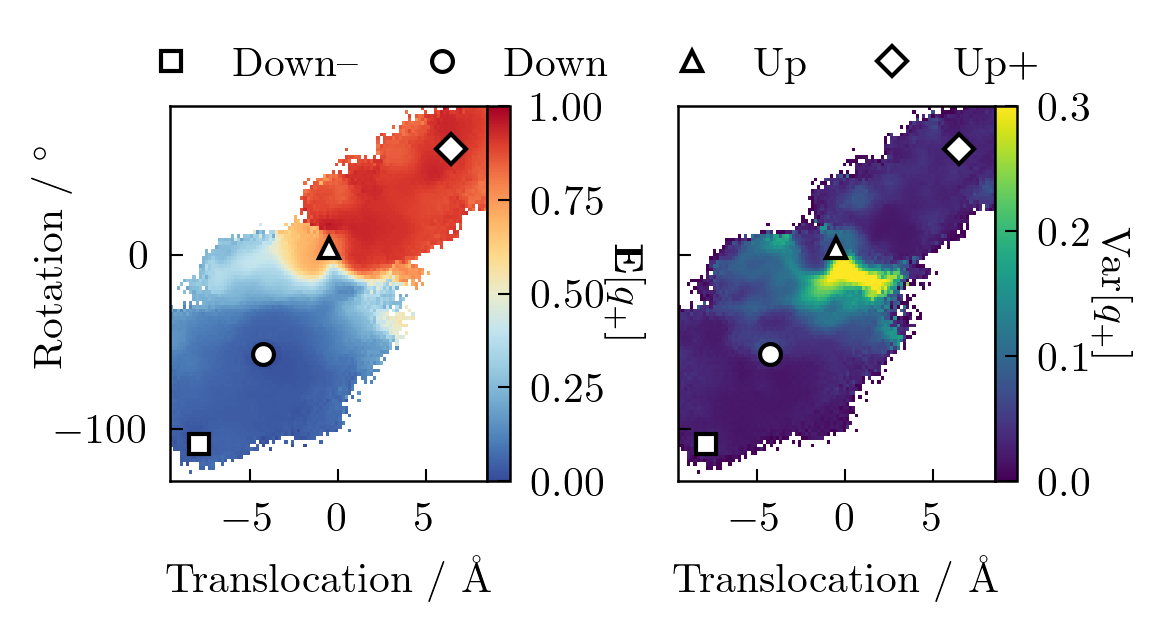

In [72]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(4, 2), dpi=300, sharex=True, sharey=True)

xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1
levels = np.linspace(vmin, vmax, 51)
q_avg = extq.projection.average2d(dist, rot, qp_du, weights, xe, ye)

qp_sq = [q ** 2 for q in qp_du]
q_avg_sq = extq.projection.average2d(dist, rot, qp_sq, weights, xe, ye)
q_std = np.sqrt(q_avg_sq - q_avg ** 2)

plotting.plot_models(ax0, models, ms=5, zorder=5)
plotting.plot_models(ax1, models, ms=5, zorder=5)
fig.legend(
    bbox_to_anchor=(0.5, 0.97),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)

pc0 = ax0.pcolormesh(xe, ye, q_avg.T, cmap="diverging", vmin=0, vmax=1)
cb0 = pplt.colorbar(pc0)
cb0.set_label("$\mathbf{E}[q_+]$", rotation=-90, labelpad=10)
pc1 = ax1.pcolormesh(xe, ye, q_std.T, vmax=0.3)
cb1 = pplt.colorbar(pc1)
cb1.set_label("$\mathrm{Var}[q_+]$", rotation=-90, labelpad=10)

for ax in (ax0, ax1):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel("Translocation / Å")
    ax.set_ylabel("Rotation / $^\circ$", labelpad=-4.0, y=0.6)
    ax.label_outer()
plt.tight_layout()

# IVAC CVs

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/4434769/ipykernel_3595825/476108860.py:16: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg**2)


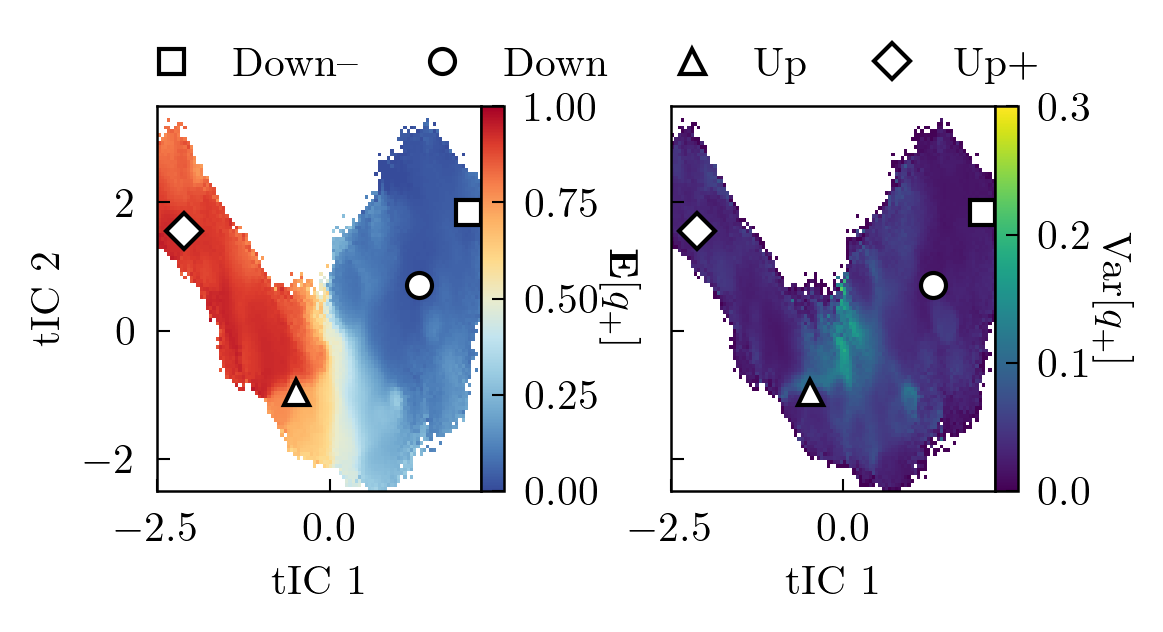

In [71]:
# compute E[\theta(x) S_tq_+(x)]
tic1 = [t[:, 1] for t in ivac_trajs]
tic2 = [t[:, 2] for t in ivac_trajs]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(4, 2), dpi=300, sharex=True, sharey=True)

xe = np.linspace(-2.5, 2.2, 101)
ye = np.linspace(-2.5, 3.5, 101)
levels = np.linspace(vmin, vmax, 51)
q_avg = extq.projection.average2d(tic1, tic2, qp_du, weights, xe, ye)

qp_sq = [q ** 2 for q in qp_du]
q_avg_sq = extq.projection.average2d(tic1, tic2, qp_sq, weights, xe, ye)
q_std = np.sqrt(q_avg_sq - q_avg ** 2)

plotting.plot_models(ax0, ivac_models[:, 1:3], ms=6, zorder=5)
plotting.plot_models(ax1, ivac_models[:, 1:3], ms=6, zorder=5)
fig.legend(
    bbox_to_anchor=(0.5, 0.97),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5,
)

pc0 = ax0.pcolormesh(xe, ye, q_avg.T, cmap="diverging", vmin=0, vmax=1)
cb0 = pplt.colorbar(pc0)
cb0.set_label("$\mathbf{E}[q_+]$", rotation=-90, labelpad=10)
pc1 = ax1.pcolormesh(xe, ye, q_std.T, vmax=0.3)
cb1 = pplt.colorbar(pc1)
cb1.set_label("$\mathrm{Var}[q_+]$", rotation=-90, labelpad=10)

for ax in (ax0, ax1):
    ax.set_xlabel("tIC 1")
    ax.set_ylabel("tIC 2")
    ax.label_outer()
plt.tight_layout()

# Salt bridge distances

In [77]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")

/scratch/local/jobs/4434769/ipykernel_3595825/1505420724.py:17: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg ** 2)
/scratch/local/jobs/4434769/ipykernel_3595825/1505420724.py:31: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe7d7bf34f0> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(


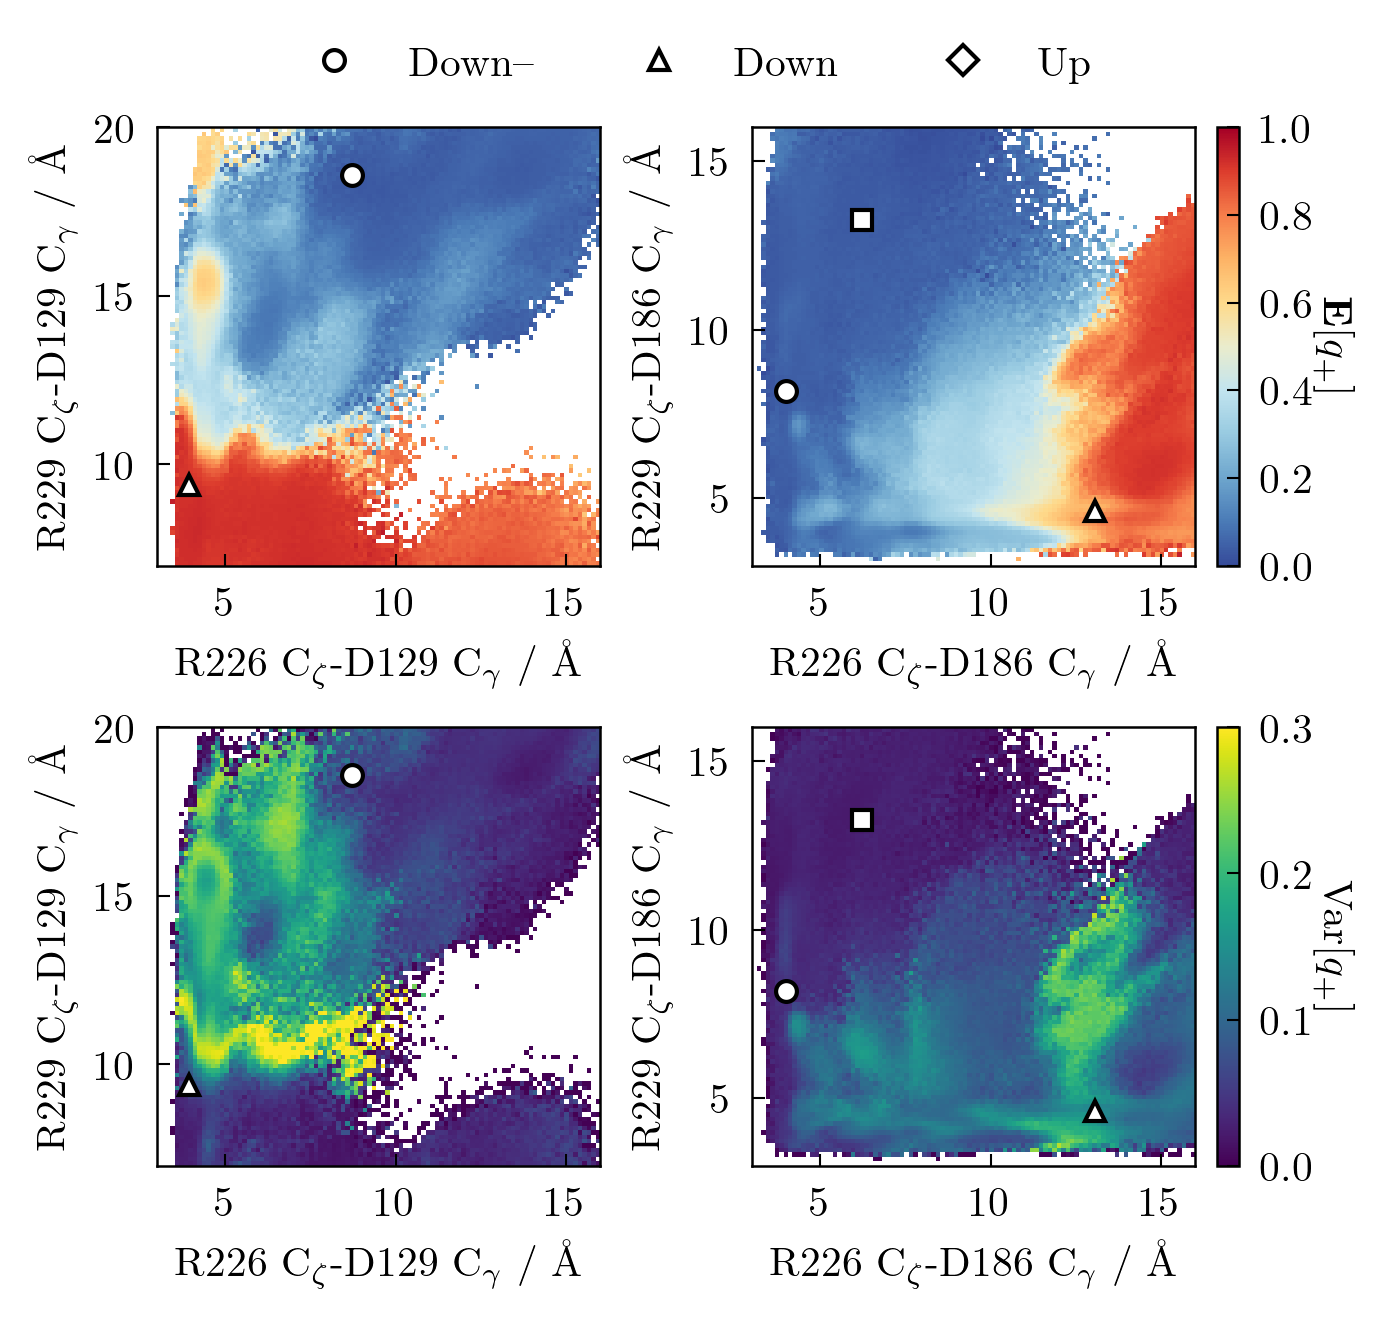

In [84]:
f, axes = plt.subplots(2, 2, figsize=(4.5, 4), dpi=300, constrained_layout=True)

range0 = [[3, 16], [7, 20]]
range1 = [[3, 16], [3, 16]]
nbin = 100
for i, ((sb1, sb2), r) in enumerate(zip(((42, 48), (47, 53)), (range0, range1))):
    sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)

    q_avg = extq.projection.average2d(sb1_trajs, sb2_trajs, qp_du, weights, xlim, ylim)
    qp_sq = [q ** 2 for q in qp_du]
    q_avg_sq = extq.projection.average2d(
        sb1_trajs, sb2_trajs, qp_sq, weights, xlim, ylim
    )
    q_std = np.sqrt(q_avg_sq - q_avg ** 2)

    h = axes[0, i].pcolormesh(xlim, ylim, q_avg.T, cmap=cm_div, vmin=0, vmax=1)
    pc = axes[1, i].pcolormesh(xlim, ylim, q_std.T, vmax=0.3)
    for ax in axes[:, i]:
        ax.set(
            xlim=r[0],
            ylim=r[1],
            xlabel=f"{sb_names[sb1]} / Å",
            ylabel=f"{sb_names[sb2]} / Å",
        )
        plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5)


f.legend(
    bbox_to_anchor=(0.5, 1.03),
    loc="center",
    ncol=3,
    labels=["_blank", "Down–", "Down", "Up"],
)
cb0 = plt.colorbar(h, ax=axes[0, 1])
cb0.set_label("$\mathbf{E}[q_+]$", rotation=-90, labelpad=10)
cb1 = plt.colorbar(pc, ax=axes[1, 1])
cb1.set_label("$\mathrm{Var}[q_+]$", rotation=-90, labelpad=10)

# plt.tight_layout()

/scratch/local/jobs/4434769/ipykernel_3595825/2350197833.py:17: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg ** 2)
/scratch/local/jobs/4434769/ipykernel_3595825/2350197833.py:31: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe85d145f40> has a label of '_blank' which cannot be automatically added to the legend.
  f.legend(


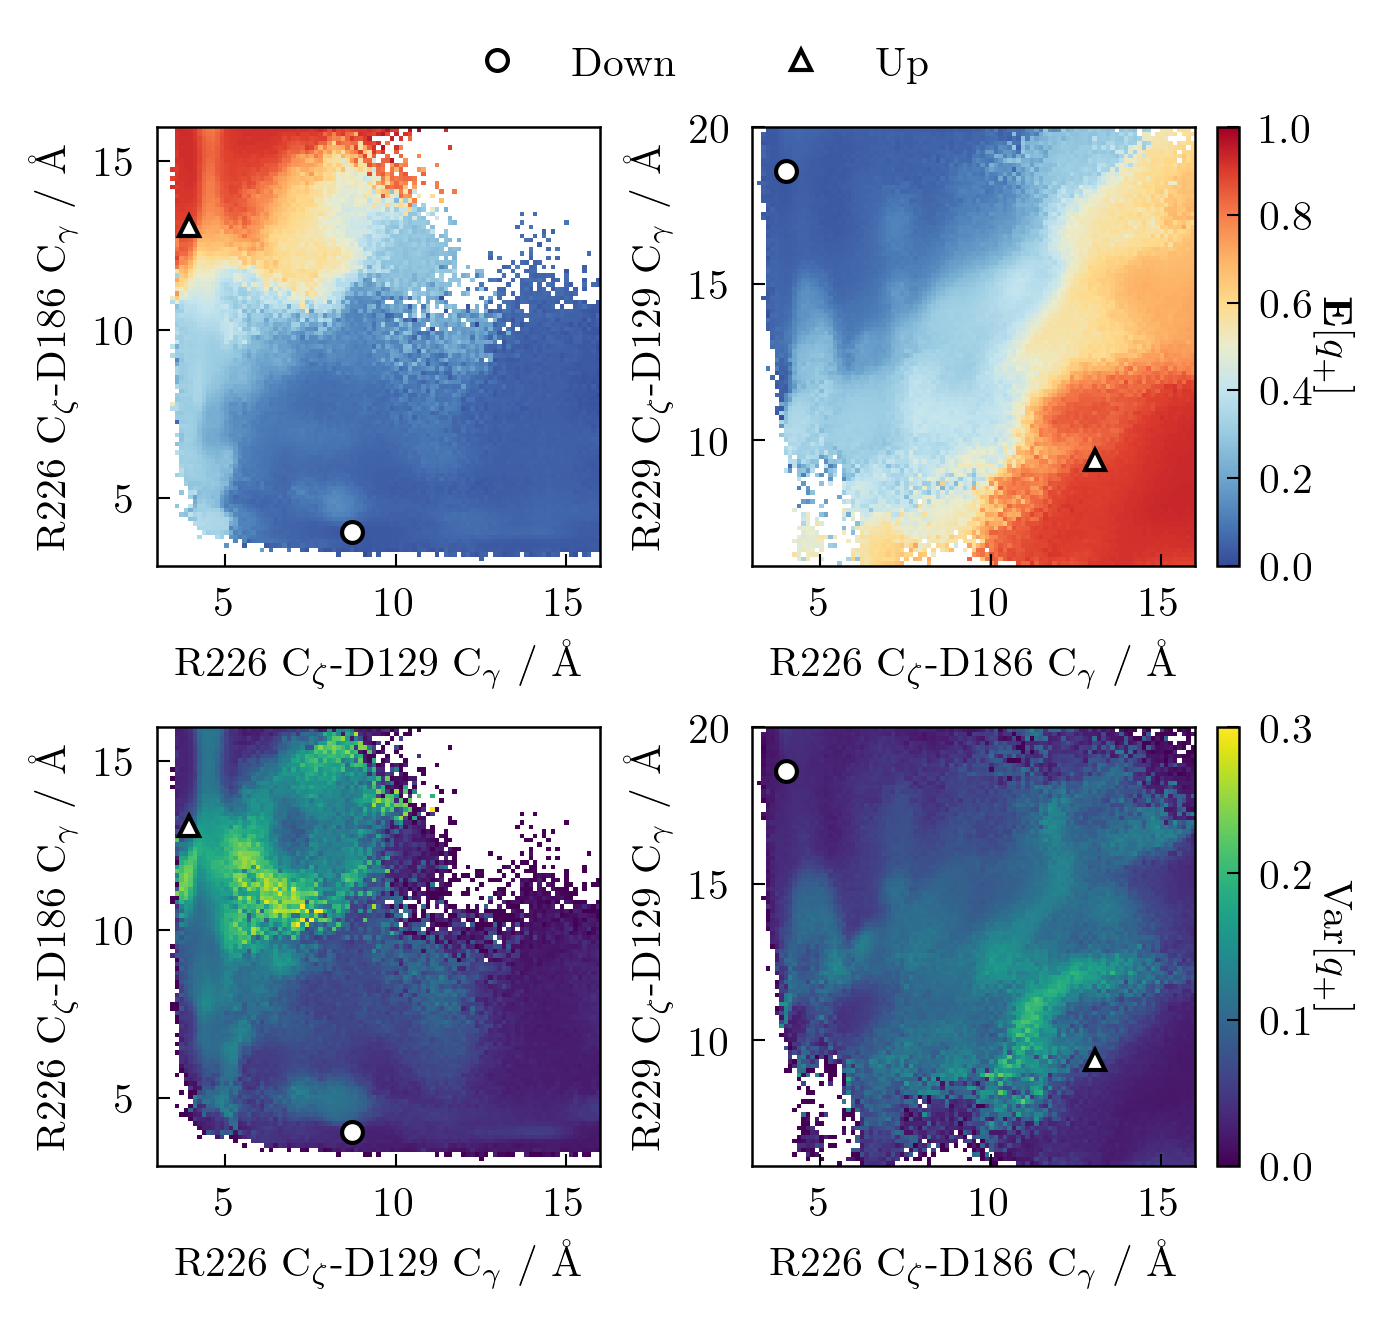

In [88]:
f, axes = plt.subplots(2, 2, figsize=(4.5, 4), dpi=300, constrained_layout=True)

range0 = [[3, 16], [3, 16]]
range1 = [[3, 16], [6, 20]]
nbin = 100
for i, ((sb1, sb2), r) in enumerate(zip(((42, 47), (47, 48)), (range0, range1))):
    sb1_trajs = [t[:, sb1] * 10 for t in sb_trajs]
    sb2_trajs = [t[:, sb2] * 10 for t in sb_trajs]
    xlim = np.linspace(*r[0], nbin)
    ylim = np.linspace(*r[1], nbin)

    q_avg = extq.projection.average2d(sb1_trajs, sb2_trajs, qp_du, weights, xlim, ylim)
    qp_sq = [q ** 2 for q in qp_du]
    q_avg_sq = extq.projection.average2d(
        sb1_trajs, sb2_trajs, qp_sq, weights, xlim, ylim
    )
    q_std = np.sqrt(q_avg_sq - q_avg ** 2)

    h = axes[0, i].pcolormesh(xlim, ylim, q_avg.T, cmap=cm_div, vmin=0, vmax=1)
    pc = axes[1, i].pcolormesh(xlim, ylim, q_std.T, vmax=0.3)
    for ax in axes[:, i]:
        ax.set(
            xlim=r[0],
            ylim=r[1],
            xlabel=f"{sb_names[sb1]} / Å",
            ylabel=f"{sb_names[sb2]} / Å",
        )
        plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=5)


f.legend(
    bbox_to_anchor=(0.5, 1.03),
    loc="center",
    ncol=3,
    labels=["_blank", "Down", "Up"],
)
cb0 = plt.colorbar(h, ax=axes[0, 1])
cb0.set_label("$\mathbf{E}[q_+]$", rotation=-90, labelpad=10)
cb1 = plt.colorbar(pc, ax=axes[1, 1])
cb1.set_label("$\mathrm{Var}[q_+]$", rotation=-90, labelpad=10)

# plt.tight_layout()